In [24]:
import pandas as pd
import numpy as np

base_path = '../Backtests/'

In [25]:
# Rebalance on percent divergence
class PercentRebalance(object):
    def __init__(self, percent_target):
        self.rebalance_count = 0
        self.percent_target = percent_target
        
    def rebalance(self, row, weights, date):
        total = row.sum()
        rebalanced = row
        rebalanced = np.multiply(total, weights)
        if np.any(np.abs((row-rebalanced)/rebalanced) > (self.percent_target/100.0)):
            self.rebalance_count = self.rebalance_count + 1
            return rebalanced
        else:
            return row

# Rebalance on calendar
class MonthRebalance(object):
    def __init__(self, months):
        self.month_to_rebalance = months
        self.rebalance_count = 0
        self.last_rebalance_month = 0

    def rebalance(self, row, weights, date):
        current_month = date.month

        if self.last_rebalance_month != current_month:
            total = row.sum()
            rebalanced = np.multiply(weights, total)
            self.rebalance_count = self.rebalance_count + 1
            self.last_rebalance_month = date.month
            return rebalanced
        else:
            return row

In [26]:

# Calculate the rebalanced combination
def calc_rebalanced_returns(returns, rebalancer, weights):
    returns = returns.copy() + 1
    
    # create a numpy ndarray to hold the cumulative returns
    cumulative = np.zeros(returns.shape)
    cumulative[0] = np.array(weights)

    # also convert returns to an ndarray for faster access
    rets = returns.values

    # using ndarrays all of the multiplicaion is now handled by numpy
    for i in range(1, len(cumulative) ):
        np.multiply(cumulative[i-1], rets[i], out=cumulative[i])
        cumulative[i] = rebalancer.rebalance(cumulative[i], weights, returns.index[i])

    # convert the cumulative returns back into a dataframe
    cumulativeDF = pd.DataFrame(cumulative, index=returns.index, columns=returns.columns)

    # finding out how many times rebalancing happens is an interesting exercise
    print ("Rebalanced {} times".format(rebalancer.rebalance_count))

    # turn the cumulative values back into daily returns
    rr = cumulativeDF.pct_change() + 1
    rebalanced_return = rr.dot(weights) - 1
    return rebalanced_return

def get_strat(strat):
    df = pd.read_csv(base_path + strat + '.csv', index_col=0, parse_dates=True, names=[strat] )
    return df

In [40]:
# Use monthly rebalancer, one month interval
rebalancer = MonthRebalance(1)

# Define strategies and weights
portfolio = {
    'core_trend': 0.25,
    'counter_trend': 0.25,
    'curve_trading': 0.25,
    'time_return': 0.25,
}

# Read all the files into one DataFrame
df = pd.concat(
        [
            pd.read_csv('{}{}.csv'.format(
                        base_path,
                        strat
                        ), 
                        index_col=0,
                        parse_dates=True,
                        names=[strat]
                       ).pct_change().dropna()
            for strat in list(portfolio.keys())
        ], axis=1
)

# Calculate the combined portfolio
df['Combined'] = calc_rebalanced_returns(
    df, 
    rebalancer, 
    weights=list(portfolio.values())
    )

df.dropna(inplace=True)



Rebalanced 217 times


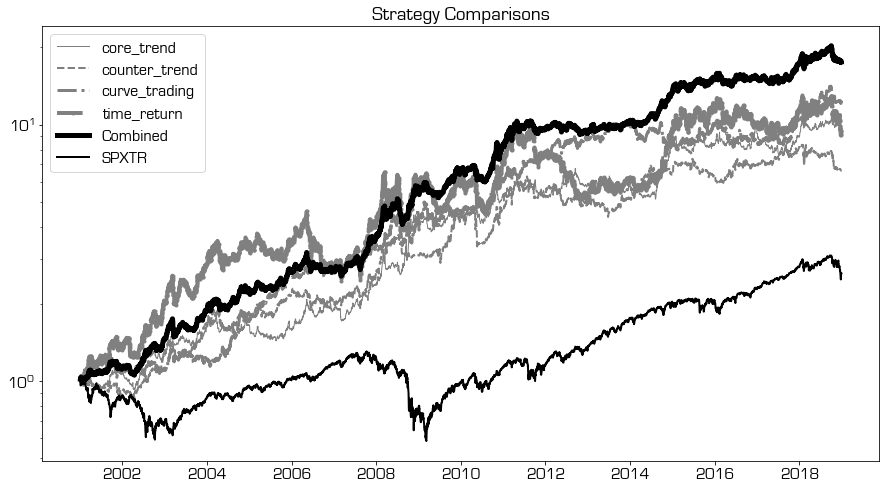

In [43]:
# Make Graph
import matplotlib 
import matplotlib.pyplot as plt

include_combined = True
include_benchmark = True
benchmark = 'SPXTR'

if include_benchmark:
    returns[benchmark] = get_strat(benchmark).pct_change()

#returns = returns['2003-1-1':]
normalized = (returns+1).cumprod()

font = {'family' : 'eurostile',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)


fig = plt.figure(figsize=(15, 8))

# First chart
ax = fig.add_subplot(111)
ax.set_title('Strategy Comparisons')

dashstyles = ['-','--','-.','.-.', '-']
i = 0
for strat in normalized:
    if strat == 'Combined':
        if not include_combined:
            continue
        clr = 'black'
        dash = '-'
        width = 5
    elif strat == benchmark:
        if not include_benchmark:
            continue
        clr = 'black'
        dash = '-'
        width = 2
    #elif strat == 'equity_momentum':
    #    continue

    else:
        clr = 'grey'
        dash = dashstyles[i]
        width = i + 1
        i += 1
    ax.semilogy(normalized[strat], dash, label=strat, color=clr, linewidth=width)
    
    ax.legend()

In [37]:
df.to_clipboard()

In [33]:
portfolio = {
    'x': 1,
    'y': 2,
    'z': 3
    
}
#print(portfolio.values())

x = np.array(list(portfolio.keys()))
             
print(x)


['y' 'x' 'z']
